## About Customer Segmentation
In this study, it is aimed to divide the customers in the new market that an automobile company will enter into 4 segments according to the strategy determined by the sales team. 

Find out more about this dataset here: https://www.kaggle.com/vetrirah/customer

## Import Libraries and Upload Data

In [292]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder, normalize
import scipy.cluster.hierarchy  as shc
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans

In [293]:
# Load Data
data = pd.read_csv("customers (1).csv")

## Understand Data

In [294]:
# Display Data
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


#### Brief About Terms/Variables:
- ***Work_Experience*** = Work experience in years  
- ***Family_Size*** = Number of family members for the customer (including the customer)  
- ***Var_1*** = Anonymised category for the customer  

In [295]:
# Display Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


- There are 2627 entries which is the Potential Customer Count  
- We have 10 features (6 categorical, 4 numerical)  
- There is NULL values.  

In [296]:
# Display Data Description
data.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


---
#### Duplicate Values

In [297]:
# Remove Duplicate Rows
print("Duplicate Data Sum: ", data.duplicated().sum())
if data.duplicated().sum() != 0:
    print("Before Removing Duplicates:", data.shape[0]) 
    data.drop_duplicates()
    print("After Removing Duplicates:", data.shape[0]) 

Duplicate Data Sum:  0


---
#### Null Values

In [298]:
# Check Null Values
null_data = pd.concat([pd.DataFrame(data.isnull().sum()), pd.DataFrame((100*data.isnull().sum()/len(data)).round(2))], axis=1)
null_data.columns = ["NaN Data", "NaN (%)"]
null_data.sort_values(ascending=False, by="NaN Data")

,NaN Data,NaN (%)
Work_Experience,269,10.24
Family_Size,113,4.30
Ever_Married,50,1.90
Profession,38,1.45
Var_1,32,1.22
Graduated,24,0.91
ID,0,0.00
Gender,0,0.00
Age,0,0.00
Spending_Score,0,0.00


- There is NULL values in 6 categories.  
- Work Experince is in 1st place with 10% missing value, followed by Family_size with 4% missing value.  
- Others only have 1-2% missing value.  
- I decided to fill them.  


In [299]:
# Fill Null Values
for i in data.columns:
    if sum(data[i].isna()) != 0:
        if i in ["Ever_Married", "Profession", "Graduated", "Var_1"]:
            data[i] = data[i].fillna(data[i].mode().values[0])
        if i in ["Work_Experience", "Family_Size"]:
            data[i] = data[i].ffill(axis=0)

# fillna - ffill - bfill 
""" train_data["Family_Size"] = train_data["Family_Size"].fillna(3)                                             # Fill with "3"
# train_data["Ever_Married"] = train_data["Ever_Married"].fillna(train_data["Ever_Married"].mode().values[0])   # Fill with mode value
# train_data["Ever_Married"] = train_data["Ever_Married"].ffill(axis = 0)                                       # Fill with previous value
# train_data["Ever_Married"] = test_data["Ever_Married"].bfill(axis = 0)                                        # Fill with next value  """

# Check Null Values
data.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

---
#### Nunique & Unique Values

In [300]:
# Explore Unique Values
column_names = list(data.columns)
for col_name in column_names:
    print(col_name, ':', data[col_name].nunique())

ID : 2627
Gender : 2
Ever_Married : 2
Age : 67
Graduated : 2
Profession : 9
Work_Experience : 15
Spending_Score : 3
Family_Size : 9
Var_1 : 7


In [301]:
# Explore Unique Values
cols = ["Profession", "Spending_Score"]

for col in cols: 
    if isinstance(col, str):
        print(f"{col}:", data[col].unique())

Profession: ['Engineer' 'Healthcare' 'Artist' 'Executive' 'Marketing' 'Doctor'
 'Lawyer' 'Entertainment' 'Homemaker']
Spending_Score: ['Low' 'Average' 'High']


---

### What are the distributions of Gender, Marriage, Graduation and Spending Score?

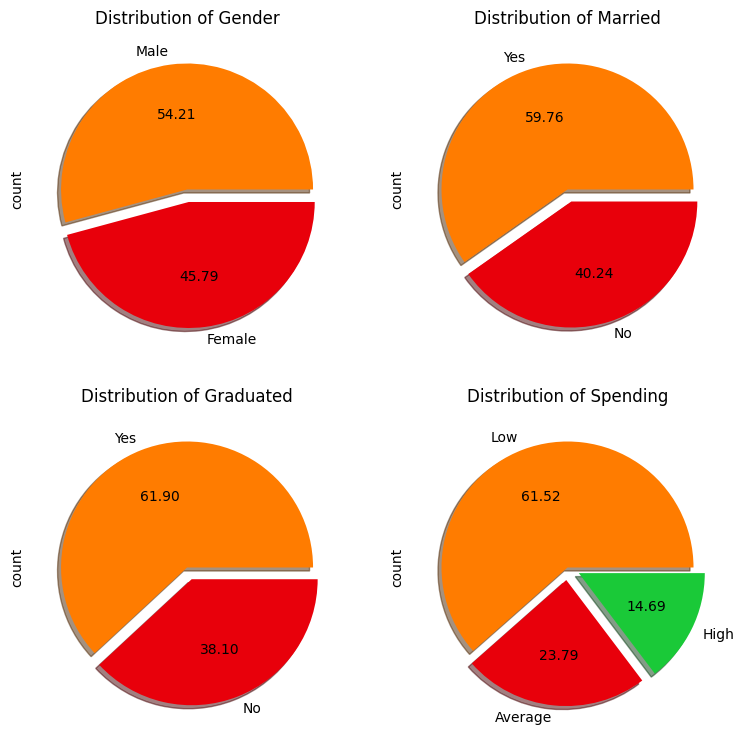

In [302]:
# Plot Pie for Gender, Ever_Married, Graduated and Spending_Score

f, ax  = plt.subplots(2,2,figsize = (9,9))
colors=["#FF7C00", "#E8000B","#1AC938"]
data["Gender"].value_counts().plot.pie(title="Distribution of Gender",explode=[0,.1],
                                           ax=ax[0][0],autopct="%.2f",shadow = True,colors = colors)

data["Ever_Married"].value_counts().plot.pie(title="Distribution of Married",explode=[0,.1],
                                                 ax=ax[0][1],autopct="%.2f",shadow = True,colors = colors)

data["Graduated"].value_counts().plot.pie(title="Distribution of Graduated",explode=[0,.1],
                                              ax=ax[1][0],autopct="%.2f",shadow = True,colors = colors)

data["Spending_Score"].value_counts().plot.pie(title="Distribution of Spending",
                                                   ax=ax[1][1],explode=[0,.1,.1],autopct="%.2f",shadow = True,colors=colors)

f.patch.set_facecolor("white")
plt.show()

When we look at the Distribution of Gender, Marriage, Graduation and Spending Score,  
we see that most customers are **Men**, **Graduated**, **Married** and has **Low Spending Score**.

---

### What is the distribution of Profession Type?

In [303]:
# Count Proffession Types and Put into a Dataframe
prof_data = data.groupby(["Profession"])["Profession"].count().to_frame("count").reset_index().sort_values(ascending=False, by="count")
prof_data

,Profession,count
0,Artist,840
5,Healthcare,418
3,Entertainment,301
1,Doctor,242
2,Engineer,236
7,Lawyer,221
4,Executive,176
8,Marketing,111
6,Homemaker,82


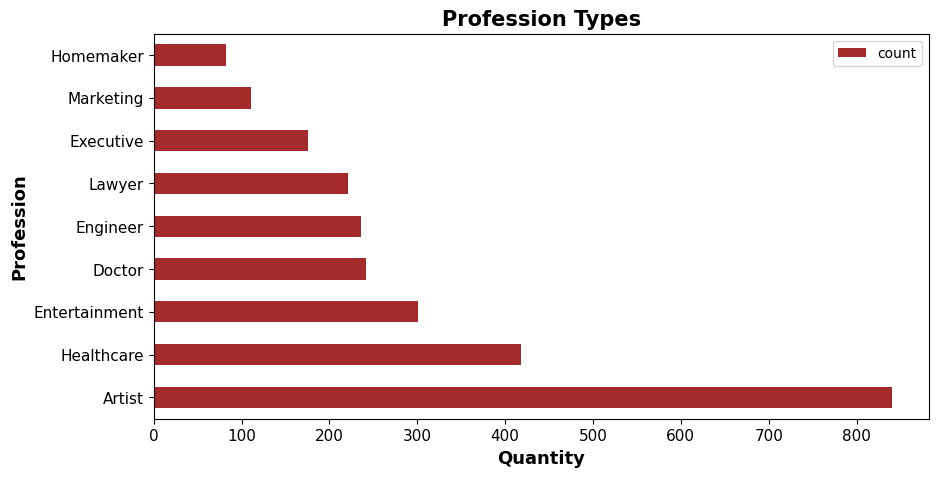

In [304]:
# Plot the Proffession Data
ax = prof_data.plot.barh(figsize = (10,5), y="count", x ="Profession", color ="brown")

# Set titles
ax.set_title("Profession Types", fontsize=15, fontweight="bold")
ax.set_ylabel("Profession", fontsize=13, fontweight="bold")
ax.set_xlabel("Quantity", fontsize=13, fontweight="bold")
ax.tick_params(axis="both", labelsize=11) 

When we look at the Distribution of Profession Type, there are **9 different types** of professionals.  
And more than half of the customers are **Artists** and **Healthcare** Professionals and especially Artists are very dominant.  

---

### What is the distribution of Family Size?

In [305]:
# Count Family Size and Put into a Dataframe
family_data = data.groupby(["Family_Size"])["Family_Size"].count().to_frame("count").reset_index()
family_data

,Family_Size,count
0,1.0,539
1,2.0,801
2,3.0,468
3,4.0,465
4,5.0,207
5,6.0,83
6,7.0,29
7,8.0,15
8,9.0,20


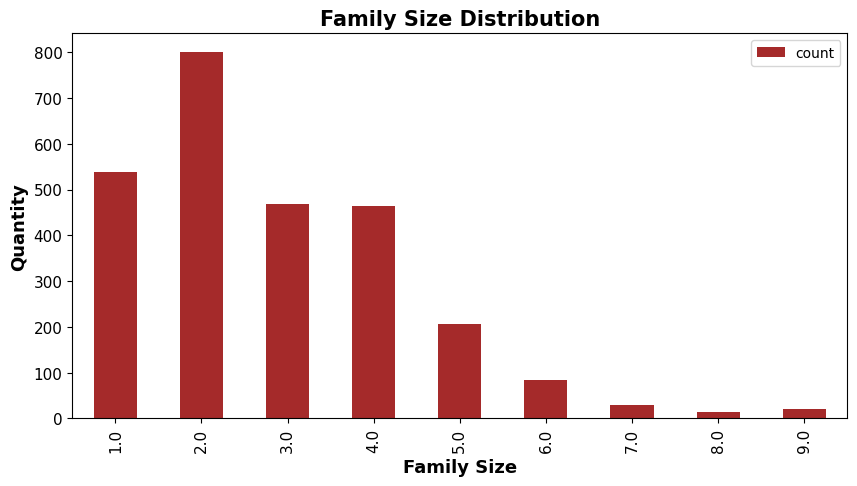

In [306]:
# Plot the Family Size Data
ax = family_data.plot.bar(figsize = (10,5), y="count", x ="Family_Size", color ="brown")

# Set titles
ax.set_title("Family Size Distribution", fontsize=15, fontweight="bold")
ax.set_ylabel("Quantity", fontsize=13, fontweight="bold")
ax.set_xlabel("Family Size", fontsize=13, fontweight="bold")
ax.tick_params(axis="both", labelsize=11) 

When we look at the Distribution of Family Size,  
Number of people in families is **between 1 and 9**, and most of them are families of **2 people**.  

---

#### Correlation Matrix

<Axes: >

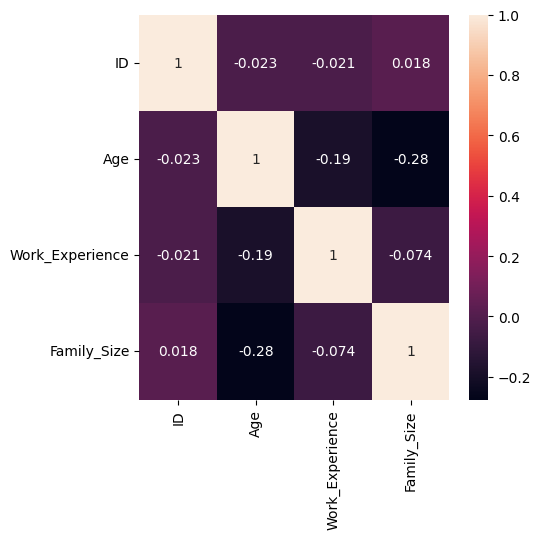

In [307]:
# Check for Correlation
corr_mat = data.corr(numeric_only =True)

# Showing Correlation Using Heatmap
plt.figure(figsize=(5,5))
sns.heatmap(corr_mat, annot=True)

---

### Label Encoder

In [308]:
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,Artist,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,11.0,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
2624,467960,Female,No,53,Yes,Entertainment,1.0,Low,2.0,Cat_6
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [309]:
# --Label Encoder

## Convert to Numerical Values Using Label Encoder
encoder = LabelEncoder()

# Converting Strings into Numbers
ID_encoded=encoder.fit_transform(data.iloc[:,0])
Gender_encoded = encoder.fit_transform(data.iloc[:,1])
Ever_Married_encoded = encoder.fit_transform(data.iloc[:,2])
Age_encoded = encoder.fit_transform(data.iloc[:,3])
Graduated_encoded = encoder.fit_transform(data.iloc[:,4])
Profession_encoded = encoder.fit_transform(data.iloc[:,5])
Work_Experience_encoded = encoder.fit_transform(data.iloc[:,6])
Spending_Score_encoded = encoder.fit_transform(data.iloc[:,7])
Family_Size_encoded = encoder.fit_transform(data.iloc[:,8])
Var_1_encoded = encoder.fit_transform(data.iloc[:,9])

# Combining Encoded Data 
data=list(zip(ID_encoded, Gender_encoded, Ever_Married_encoded, Age_encoded, Graduated_encoded, 
                    Profession_encoded, Work_Experience_encoded, Spending_Score_encoded, 
                    Family_Size_encoded, Var_1_encoded))

# Put Them in a Dataframe
data = pd.DataFrame(data, columns = ["ID", "Gender", "Ever_Married", "Age", "Graduated", "Profession", 
                                     "Work_Experience", "Spending_Score", "Family_Size", "Var_1"])

# Data After Label Encoder
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,1,16,1,2,0,2,0,5
1,1,1,1,17,1,5,8,0,3,5
2,2,0,1,46,0,0,0,2,0,5
3,3,1,1,37,0,4,11,1,1,5
4,4,0,0,1,0,8,11,2,3,5


Spending_Score {High:1 , Average:0 , Low:2}  
Gender {Male:1, Female:0}  
Ever_Maried {No:0, Yes:1}  
Graduated {No:0, Yes:1}  

In [310]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2627 non-null   int64
 1   Gender           2627 non-null   int64
 2   Ever_Married     2627 non-null   int64
 3   Age              2627 non-null   int64
 4   Graduated        2627 non-null   int64
 5   Profession       2627 non-null   int64
 6   Work_Experience  2627 non-null   int64
 7   Spending_Score   2627 non-null   int64
 8   Family_Size      2627 non-null   int64
 9   Var_1            2627 non-null   int64
dtypes: int64(10)
memory usage: 205.4 KB


---

<Axes: >

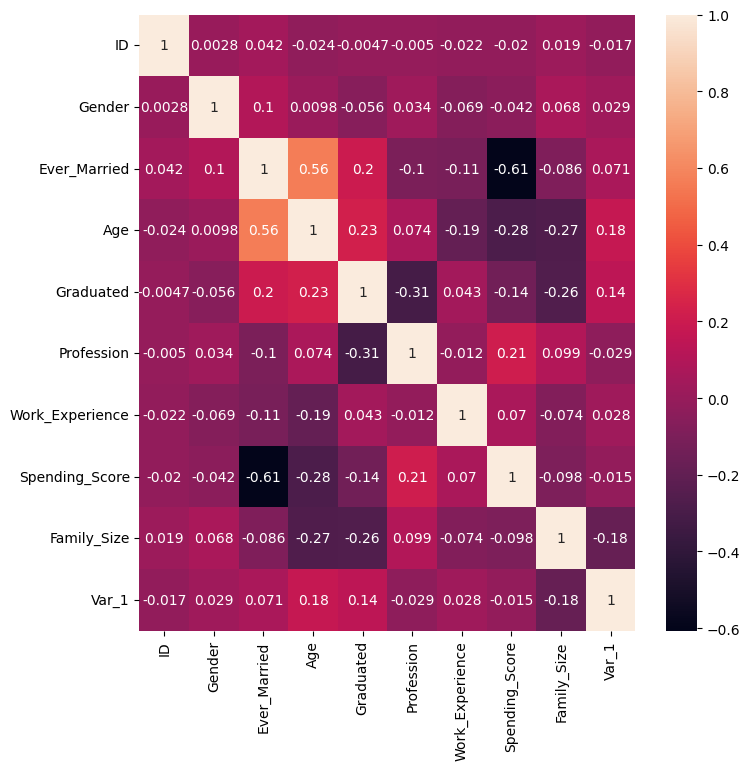

In [311]:
# Check for Correlation
corr_mat = data.corr(numeric_only =True)

# Showing Correlation Using Heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, annot=True)

In this correlation matrix after Label Encoding, we see that there is particularly a high correlation between:
- **Ever_Married**" and **Spending_Score**
- **Ever_Married**" and **Age**
- **Spending_Score** and **Age**
- **Spending_Score** and **Profession**

---

#### Normalizing the Data

In [312]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,1,16,1,2,0,2,0,5
1,1,1,1,17,1,5,8,0,3,5
2,2,0,1,46,0,0,0,2,0,5
3,3,1,1,37,0,4,11,1,1,5
4,4,0,0,1,0,8,11,2,3,5


In [313]:
# Normalizing
data_norm = normalize(data)
data_norm = pd.DataFrame(data_norm, columns=data.columns)
data_norm.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0.000000,0.000000,0.058621,0.937937,0.058621,0.117242,0.000000,0.117242,0.000000,0.293105
1,0.049029,0.049029,0.049029,0.833494,0.049029,0.245145,0.392232,0.000000,0.147087,0.245145
2,0.043133,0.000000,0.021567,0.992062,0.000000,0.000000,0.000000,0.043133,0.000000,0.107833
3,0.076348,0.025449,0.025449,0.941625,0.000000,0.101797,0.279943,0.025449,0.025449,0.127247
4,0.258199,0.000000,0.000000,0.064550,0.000000,0.516398,0.710047,0.129099,0.193649,0.322749


---

## Hierarchical  Clustering

In [314]:
## Train the Model
# I chose n_clusters as 4 because we needed to classify customers in 4 segments.
cluster =  AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage= "ward")
segmentation = list(cluster.fit_predict(data_norm))
print(segmentation)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


[3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 1, 3, 1, 0, 0, 3, 3, 3, 0, 3, 0, 1, 0, 1, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 

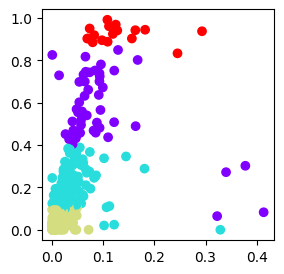

In [315]:
# Scatter Plot to Show the Clusters
plt.figure(figsize=(3,3))
plt.scatter(data_norm["Var_1"], data_norm["Age"], c=cluster.labels_, cmap="rainbow")

In [316]:
# Put Segmentation in a Dataframe
segment = pd.DataFrame(segmentation, columns = ["Segmentation"])
segment.head()

,Segmentation
0,3
1,3
2,3
3,3
4,0


In [317]:
# Load Data
raw_data = pd.read_csv("customers (1).csv")

In [318]:
# Concatinate Tables
new_data = pd.concat([pd.DataFrame(raw_data), pd.DataFrame(segment)], axis=1)
new_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,3
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,3
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,3
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,3
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,0


In [319]:
# Count Segmentation and Put into a Dataframe
segm_data = new_data.groupby(["Segmentation"])["Segmentation"].count().to_frame("Count").reset_index().sort_values(ascending=False, by="Count")
segm_data

,Segmentation,Count
2,2,2376
1,1,183
0,0,51
3,3,17


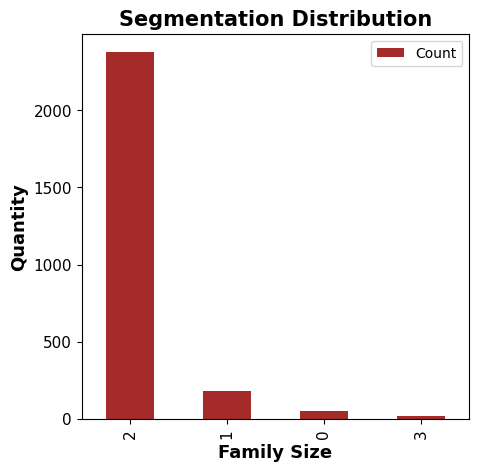

In [320]:
# Plot the Segmentation Data
ax = segm_data.plot.bar(figsize = (5,5), y="Count", x ="Segmentation", color ="brown")

# Set titles
ax.set_title("Segmentation Distribution", fontsize=15, fontweight="bold")
ax.set_ylabel("Quantity", fontsize=13, fontweight="bold")
ax.set_xlabel("Family Size", fontsize=13, fontweight="bold")
ax.tick_params(axis="both", labelsize=11) 

---

Kmeans model can also be tried.